In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Webscraping, Pandas, and EDA

<hr style="height:2.4pt">

In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pyarrow as pa # optional
import seaborn as sns
import matplotlib.pyplot as plt
import re
import io
import os.path
import json
import time
import glob
import asyncio # optional
import aiohttp # optional
from IPython.core.display import HTML
from IPython import display

In [ ]:
# For calculating total notebook runtime
notebook_start = time.time()

In [ ]:
style = '''<style>
h3, h4 {
    background-color: #7efcf5;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0em;
}
h3 {
    background-color: #7efcf5;
    border-top: 5px solid #7ec4fc;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0.5em;
}
p {
    padding: 0.5em;
    max-width: 34em;
    font-weight:400;
}
.md {
    max-width: 80ch;

}
.prompt {    
    background-color: lightgreen;
    border-color: #dFb5b4;
    border-left: 5px solid #f57efc;
    padding: 0.5em;
    font-weight:500;
    }
 </style>'''
HTML(style)

## Assignment Overview

You'll be working with data from screenboston.com, a website that aggregates movie screenings from various theaters in the Boston area. Your task is to collect this data, enrich it with information from Wikipedia, and then analyze and visualize the results.

## Assignment Structure

The assignment is divided into 8 main questions, each building upon the previous ones, followed by a wrap-up:

1. Fetching HTML from screenboston.com (10 pts)
2. Parsing HTML into structured data (15 pts)
3. Augmenting data with historical snapshots (15 pts)
4. Creating and manipulating a Pandas DataFrame (15 pts)
5. Initial exploratory data analysis and visualization (15 pts)
6. Finding Wikipedia pages for each screened film (7 pts)
7. Storing Wikipedia HTML in the DataFrame (3 pts)
8. Extracting and analyzing data from Wikipedia pages (15 pts)
9. Wrap-up (5 pts)

As you progress through these steps, you'll be transforming raw web data into a rich dataset ready for analysis. By the end, you'll have created a comprehensive overview of Boston's movie screening landscape, potentially uncovering interesting trends and patterns in the process. 

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output. Or better yet, avoid overly long output altogether.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<div class=md>
<h3>1. Getting HTML from screenboston.com</h3>

<p>Our first step is to get the HTML content from the page at screenboston.com for analysis. To avoid having to make unnecessary future requests, you should write the content to disk.</p>



<div class=prompt>
    
1. Use the `requests` library to get the html located at screenboston.com.
1. Save it in the file `data/html/screenboston.html`.

**Your code should only make an HTTP request if the file does not already exist.** 

**Hint:** the `os.path.isfile()` function can be used check if a file exists.
</div>
</div>


In [ ]:
# get URL and file path
url = 'http://screenboston.com'
file_path = 'data/html/screenboston.html'

# Check file already exists
if not os.path.isfile(file_path):
    try:
        # Send HTTP GET request to HTML content
        response = requests.get(url)
        response.raise_for_status()  # Ensure request successful
        
        # Save the HTML content
        os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Create directories if they don't there
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"HTML content saved to {file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve the webpage: {e}")
else:
    print(f"File already exists placed at {file_path}, no need to further download.")

File already exists placed at data/html/screenboston.html, no need to further download.


In [ ]:
grader.check("q1")

q1 results: All test cases passed!

Comment: To ensure the TA can successfully re-run all my scripts, I deleted the screenboston.html file in the data/html folder, as it updates periodically. To re-run my code, the latest version of screenboston.html, retrieved on 9/22/24, was used to initialize the 'movies' dictionary in the final trial.

<div class=md>
<h3>2. Parsing HTML into an Efficient Data Structure</h3>

<p>Were you to open this HTML file in an editor, you'd find it wouldn't make for light reading.
There's a lot of text in there, but we're currently only interested in a small portion of it. Thankfully, this small portion's constituant occurances appear in a mostly predictable way.
</p>

<div class='prompt'>
1. Parse the HTML page to produce an iterable of dictionaries called <code>movies</code>. Here is one possible example:
<div style="max-width:30em;padding:1em">
    
```python
{'title': 'Monty Python and the Holy Grail',
 'directors': 'Terry Jones, Terry Gilliam',
 'year': 1975,
 'genre': 'Adventure',
 'runtime': '1h 31m',
 'theater': 'Coolidge Corner Theater',
 'screen_date': '2024-08-17'
 'screen_times': '11:59 PM'}
```
</div>

2. Report the number of dictionaries in your iterable.
3. Display an example dictionary.
</div>

<p>
<b>One possible approach:</b> leveraging the structure of the page, use BeautifulSoup to divide it into disjoint peices of the HTML tree, each containing the set of information outlined above for each title's screening date at a given theater. Each peice is processed by a helper function(s) which extracts the desired fields and assemples them into a dictionary. These dictionaries are then accumulated in some iterable such as a list.
</p>

**Hints:**
- Your browser's 'inspect' tool is very useful for exploring a page's structure.
- To maintain a uniform set of keys across all movie dictionaries, use the plural 'directors' even for movies which attribute only a single director. 
</div>
</div>

In [ ]:
from datetime import datetime  # Import the datetime module

# define function to extract movie information
def extract_movie_info(movie_section, screen_date):
    title = movie_section.find('p', class_='big').text.strip()
    director = movie_section.find('p', class_='').text.strip()

    # Extract details (year, genre, runtime)
    details = movie_section.find_all('p', class_='')[1].text.strip().split(', ')
    year = int(details[0]) if len(details) > 0 else None
    genre = details[1] if len(details) > 1 else None
    runtime = details[2] if len(details) > 2 else None

    # Extract theater and screen times
    theater = None
    screen_times = []
    flex_div = movie_section.find('div', class_='flex')
    if flex_div:
        p_tags = flex_div.find_all('p')
        
        # Loop through p tags to extract theater and screen times
        for p_tag in p_tags:
            text = p_tag.text.strip()
            # Only retrieve times containing 'AM' or 'PM'
            if 'AM' in text or 'PM' in text:  
                screen_times.append(text)
            else:
                theater = text

    # Convert screen_date to a readable format
    screen_date_formatted = datetime.strptime(screen_date, '%Y-%m-%d').strftime('%B %d, %Y')

    # Join the screen_times list into a single string separated by commas
    screen_times_str = ', '.join(screen_times) if screen_times else None

    return {
        'title': title,
        'directors': director,
        'year': year,
        'genre': genre,
        'runtime': runtime,
        'theater': theater,
        'screen_date': screen_date_formatted,  
        'screen_times': screen_times_str  # Return as a single string or None if no valid times
    }



# Load and parse the HTML file
file_path = 'data/html/screenboston.html'
with open(file_path, 'r', encoding='utf-8') as file:
    soup = BeautifulSoup(file, 'html.parser')

# Initialize an empty list for movies
movies = []

# Find all date sections (they have id="YYYY-MM-DD" format)
date_sections = soup.find_all('div', id=True)

# Iterate through each date section to get movies on that date
for date_section in date_sections:
    screen_date = date_section['id']  # Extract the screening date from the div's id attribute

    # Find all movie sections under this date
    movie_sections = date_section.find_all('button', class_='w-full h-auto max-w-full text-left')

    # Parse each movie section and add it to the list of movies
    for movie_section in movie_sections:
        try:
            movie_info = extract_movie_info(movie_section, screen_date)
            movies.append(movie_info)
        except Exception as e:
            print(f"Error processing movie section: {e}")

# Report the number of movies and display an example
print(f"Number of movies: {len(movies)}")
if movies:
    print("Example movie:", movies[0])

Number of movies: 114
Example movie: {'title': 'Harper', 'directors': 'Jack Smight', 'year': 1966, 'genre': 'Mystery', 'runtime': '2h 1m', 'theater': 'The Brattle', 'screen_date': 'September 18, 2024', 'screen_times': '4:00 PM'}


In [ ]:
grader.check("q2")

q2 results: All test cases passed!

<div class=md>
    <h3>3. Adding Historical Data: Snapshots from the Internet Archive's Wayback Machine</h3>
<p>
The screenboston.com page only shows screenings scheduled from the current day until about 2-4 weeks into the future.
Using the <a href="http://web.archive.org/">Wayback Machine</a>, we can augment our dataset with past snapshots of the page  
</p>

<p>
Rather than clicking around to download each snapshot manually, we should again acquire our pages programmatically using <code>requests</code>. The Internet Archive offers an <a href='https://archive.org/help/wayback_api.php'>API</a> where you can specify a URL and timestamp and receive a JSON object which contains a new URL to a snapshot of the desired page nearest to the provided timestamp. You can then use <code>requests</code> again to acquire the HTML of this snapshot.
</p>
    
<div class=prompt>

1. Acquire enough snapshots to cover all days from Jan through September 2024 for which there exists data. 
For simplicity we'll assume that any well-formed screenboston.com page will cover at least through the end of that month and that a day's schedule won't change once displayed.
2. Write each snapshot's HTML content to disk in the `/data/html` directory using filenames of the form `'snapshot_YYYYMMDD.html'`. Your code should only make requests if no local snapshot files already exist.
3. Using your parsing function from the previous section, add movie dictionaries extracted from all the snapshots to your list, `movies`. Save this list of dictionaries as 'data/movies.json'. You should only perform the parsing if the JSON file does not already exist. Don't worry about any duplicate movie screenings in your list at this point.

</div>

**Hints:**
- When retrieving JSON content with <code>requests</code>, us the `json()` method rather than the `text` attribute to extract the content from the returned request object into a nested dictionary rather than a string.
- APIs often take parameters as key-value pairs occuring after a '?' character in the URL. For example 'http://archive.org/wayback/available?url=example.com&timestamp=20060101' includes a 'url' and a 'timestamp' parameter. When using <code>requests.get()</code> you can exclude these parameters from the URL itself and instead pass them as a dictionary to an argument called 'params'.
- Use <code>json.dump()</code> and <code>json.load()</code> from the imported <code>json</code> module for writing and reading JSON content.

In [ ]:
import os
from datetime import timedelta

# Base directory for HTML files and the JSON file
html_dir = 'data/html/'
json_file = 'data/movies.json'

# The base URL for the Wayback Machine API
wayback_api_url = 'http://archive.org/wayback/available'

# The target URL to be archived
target_url = 'http://screenboston.com'

# Function to check if an HTML snapshot already exists
def snapshot_exists(date_str):
    return os.path.exists(os.path.join(html_dir, f'snapshot_{date_str}.html'))

# Function to save the HTML snapshot to a file
def save_html_snapshot(date_str, html_content):
    with open(os.path.join(html_dir, f'snapshot_{date_str}.html'), 'w', encoding='utf-8') as file:
        file.write(html_content)

# Function to get a Wayback Machine snapshot for a given date
def get_wayback_snapshot(date_str):
    params = {
        'url': target_url,
        'timestamp': date_str
    }
    try:
        response = requests.get(wayback_api_url, params=params, timeout=10)  # Add a timeout
        response.raise_for_status()  # Raise an exception for bad HTTP responses
        snapshot_info = response.json()
        
        if 'archived_snapshots' in snapshot_info and 'closest' in snapshot_info['archived_snapshots']:
            snapshot_url = snapshot_info['archived_snapshots']['closest']['url']
            html_response = requests.get(snapshot_url, timeout=10)
            return html_response.text
    except requests.exceptions.RequestException as e:
        print(f"Error acquiring snapshot for {date_str}: {e}")
        return None

# Function to acquire snapshots from Jan 2024 through September 2024
def acquire_snapshots():
    # Start from Jan 1, 2024
    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 9, 30)
    current_date = start_date

    # Make sure the directory exists
    os.makedirs(html_dir, exist_ok=True)

    # Loop through each day between Jan 1, 2024 and Sept 30, 2024
    while current_date <= end_date:
        date_str = current_date.strftime('%Y%m%d')
        
        if not snapshot_exists(date_str):
            print(f"Acquiring snapshot for {date_str}...")
            html_content = get_wayback_snapshot(date_str)
            
            if html_content:
                save_html_snapshot(date_str, html_content)
            
            # Add a delay to prevent overloading the server
            time.sleep(1)  # Add a 1-second delay between requests
        
        current_date += timedelta(days=1)

# Main function to acquire snapshots and parse movie data
def main():
    # Acquire snapshots if not already saved
    acquire_snapshots()

if __name__ == '__main__':
    main()

In [ ]:
# Define the starting and ending dates
start_date = datetime(2024, 1, 1)  # January 1, 2024
end_date = datetime(2024, 9, 30)   # 9/30, 2024

# Initialize the current date as the start date
current_date = start_date

# Loop through each day in the date range
while current_date <= end_date:
    # Format the date as YYYYMMDD
    date_str = current_date.strftime('%Y%m%d')

    # Create the file path for the current date
    file_path = f'data/html/snapshot_{date_str}.html'
    
    try:
        # Load and parse the HTML file
        with open(file_path, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')

        # Find all date sections (they have id="YYYY-MM-DD" format)
        date_sections = soup.find_all('div', id=True)

        # Iterate through each date section to get movies on that date
        for date_section in date_sections:
            screen_date = date_section['id']  # Extract the screening date from the div's id attribute

            # Find all movie sections under this date
            movie_sections = date_section.find_all('button', class_='w-full h-auto max-w-full text-left')

            # Parse each movie section and add it to the list of movies
            for movie_section in movie_sections:
                movie_info = extract_movie_info(movie_section, screen_date)
                movies.append(movie_info)
                
        print(f"Processed file: {file_path}")

    except FileNotFoundError:
        print(f"File not found: {file_path}")

    # Move to the next day
    current_date += timedelta(days=1)

# At this point, movies contains data from all files processed
print(f"Total movies parsed: {len(movies)}")

# Define the output JSON file path
output_json_path = 'data/movies.json'

# Write the list of movies to a JSON file
os.makedirs(os.path.dirname(output_json_path), exist_ok=True)  # Ensure the directory exists

with open(output_json_path, 'w', encoding='utf-8') as json_file:
    json.dump(movies, json_file, indent=4)

print(f"Movies information saved to {output_json_path}")

Processed file: data/html/snapshot_20240101.html
Processed file: data/html/snapshot_20240102.html
Processed file: data/html/snapshot_20240103.html
Processed file: data/html/snapshot_20240104.html
Processed file: data/html/snapshot_20240105.html
Processed file: data/html/snapshot_20240106.html
Processed file: data/html/snapshot_20240107.html
Processed file: data/html/snapshot_20240108.html
Processed file: data/html/snapshot_20240109.html
Processed file: data/html/snapshot_20240110.html
Processed file: data/html/snapshot_20240111.html
Processed file: data/html/snapshot_20240112.html
Processed file: data/html/snapshot_20240113.html
Processed file: data/html/snapshot_20240114.html
Processed file: data/html/snapshot_20240115.html
Processed file: data/html/snapshot_20240116.html
Processed file: data/html/snapshot_20240117.html
Processed file: data/html/snapshot_20240118.html
Processed file: data/html/snapshot_20240119.html
Processed file: data/html/snapshot_20240120.html
Processed file: data

In [ ]:
# Display info about snapshots and results of parsing
print(f"Snapshots:")
print([f.split('/')[-1] for f in glob.glob('data/html/snapshot_*')])
print(f"Found {len(movies)} movie entries across all HTML files.")

Snapshots:
['snapshot_20240321.html', 'snapshot_20240402.html', 'snapshot_20240123.html', 'snapshot_20240204.html', 'snapshot_20240105.html', 'snapshot_20240501.html', 'snapshot_20240420.html', 'snapshot_20240303.html', 'snapshot_20240222.html', 'snapshot_20240411.html', 'snapshot_20240330.html', 'snapshot_20240213.html', 'snapshot_20240114.html', 'snapshot_20240510.html', 'snapshot_20240312.html', 'snapshot_20240329.html', 'snapshot_20240806.html', 'snapshot_20240725.html', 'snapshot_20240608.html', 'snapshot_20240527.html', 'snapshot_20240923.html', 'snapshot_20240428.html', 'snapshot_20240509.html', 'snapshot_20240824.html', 'snapshot_20240905.html', 'snapshot_20240626.html', 'snapshot_20240707.html', 'snapshot_20240419.html', 'snapshot_20240815.html', 'snapshot_20240617.html', 'snapshot_20240518.html', 'snapshot_20240914.html', 'snapshot_20240716.html', 'snapshot_20240523.html', 'snapshot_20240604.html', 'snapshot_20240208.html', 'snapshot_20240127.html', 'snapshot_20240721.html', 

In [ ]:
grader.check("q3")

q3 results: All test cases passed!

<div class=md>
    
<h3>4. DataFrame Creation & Manipulation</h3>

Your variable `movies` is a list of dictionaries which you can use to create a Pandas DataFrame. Have our data in a DataFrame will make it much easier to analyze and manipulate.

<div class=prompt>
    
1. Use `movies` to create a DataFrame and call it `df`
2. Drop any **duplicate rows** and report the number of remaining rows. Here we consider duplicates to be rows in which *all* values match. The same movie screening on different days, even at the same theater, will not be considered a duplicate.
3. Check for **nans**. If you find any nans you should report the number of nans in each column and display the rows that contain at least one nan. If there are no nans then you should display output to confirm this fact.
4. Convert the **'screen_date'** to a Pandas `datetime` dtype and **'runtime'** to a Pandas `timedelta` dtype.
5. Sort your `df` by ascending 'screen_date'
</div>

Your result should look something like:

| title                            | directors       | year | genre  | runtime         | theater                   | screen_date | screen_times         |
|-----------------------------------|-----------------|------|--------|-----------------|---------------------------|-------------|----------------------|
| Ghost Dog: The Way of the Samurai | Jim Jarmusch    | 1999 | Crime  | 0 days 01:56:00 | The Brattle               | 2024-05-24  | 4:00 PM, 9:00 PM     |
| Stray Dog                        | Akira Kurosawa  | 1949 | Crime  | 0 days 02:02:00 | The Brattle               | 2024-05-24  | 6:30 PM              |
| Big Trouble in Little China       | John Carpenter  | 1986 | Comedy | 0 days 01:40:00 | Coolidge Corner Theatre    | 2024-05-24  | 11:59 PM             |
| Young Frankenstein               | Mel Brooks      | 1974 | Comedy | 0 days 01:46:00 | The Brattle               | 2024-05-25  | 12:00 PM             |
| Poetry                           | Lee Chang-dong  | 2010 | Drama  | 0 days 02:19:00 | Museum of Fine Arts        | 2024-05-25  | 2:30 PM              |

**Hints:**
- You can use the `dt.date` attribute on a datetime column to extract just the day (and ignore the time)
- You may need to to do some string parsing on 'runtime' before coverting it to a `timedelta`
- Pandas now supports [PyArrow](https://arrow.apache.org/docs/python/index.html) as a backend alternative to Numpy. This gives access to new datatypes including native strings (as opposed to the catch-all 'object'), ints that support NaN values, and others. Using these datatypes can often speed up computations so you may choose to experiment with converting some or all of your columns to these new datatypes. You can read more [here](https://pandas.pydata.org/docs/user_guide/pyarrow.html).
</div>

In [ ]:
# df1 = pd.DataFrame(movies)
# print (df1)
# # Define the output CSV file path
# csv_file_path = 'data/movies.csv'

# # Save the DataFrame to a CSV file
# df1.to_csv(csv_file_path, index=False)

In [ ]:
# Create DataFrame from movies list
df = pd.DataFrame(movies)

# Drop duplicates and count remaining rows
df_cleaned = df.drop_duplicates()
remaining_rows = len(df_cleaned)

# Check for NaNs and report columns with NaNs if found
nans = df_cleaned.isna().sum()
rows_with_nans = df_cleaned[df_cleaned.isna().any(axis=1)]

# Convert 'screen_date' to datetime and 'runtime' to timedelta
df_cleaned['screen_date'] = pd.to_datetime(df_cleaned['screen_date'])
df_cleaned['runtime'] = pd.to_timedelta(df_cleaned['runtime'])

# Sort by ascending 'screen_date'
df_sorted = df_cleaned.sort_values(by='screen_date')

df_sorted, remaining_rows, nans, rows_with_nans

# Drop duplicates based on 'title', 'screen_date', and 'theater'
df_cleaned_no_duplicates = df_sorted.drop_duplicates(subset=['title', 'screen_date', 'theater'])

# Count the remaining rows after removing duplicates
remaining_rows_no_duplicates = len(df_cleaned_no_duplicates)

# Sort the cleaned DataFrame by 'screen_date'
df_sorted_no_duplicates = df_cleaned_no_duplicates.sort_values(by='screen_date')

df_sorted_no_duplicates, remaining_rows_no_duplicates

df = df_sorted_no_duplicates

/tmp/ipykernel_1782/93025308.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['screen_date'] = pd.to_datetime(df_cleaned['screen_date'])
/tmp/ipykernel_1782/93025308.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['runtime'] = pd.to_timedelta(df_cleaned['runtime'])


In [ ]:
print(df.head())

                                 title       directors  year   genre  \
114  Ghost Dog: The Way of the Samurai    Jim Jarmusch  1999   Crime   
115                          Stray Dog  Akira Kurosawa  1949   Crime   
116        Big Trouble in Little China  John Carpenter  1986  Comedy   
124                               Ring    Hideo Nakata  1998  Horror   
117                 Young Frankenstein      Mel Brooks  1974  Comedy   

            runtime                  theater screen_date      screen_times  
114 0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM  
115 0 days 02:02:00              The Brattle  2024-05-24           6:30 PM  
116 0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM  
124 0 days 01:36:00       Somerville Theatre  2024-05-25          11:59 PM  
117 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM  


In [ ]:
grader.check("q4")

q4 results: All test cases passed!

In [ ]:
# # Define the output CSV file path
# csv_file_path = 'data/movies_0923_10pm.csv'

# # Save the DataFrame to a CSV file
# df.to_csv(csv_file_path, index=False)

<div class=md>
    
<h3>5. Initial Exploratory Data Analysis (EDA)</h3>

Using your DataFrame, perform the following exploratory data analysis tasks. Note that we'll use the term "screening" to refer to rows in the DataFrame example provided above. For each visualization component of this question you should interpret the results and draw conclusions.

<div class=prompt>

1. **Longest Films**:
   Display the rows corresponding to the top 5 longest reported runtimes in descending order.

2. **Screening Counts**:
   Create two plots as side-by-side subplots with a shared y-axis range:\
   a. Number of screenings by theater\
   b. Number of screenings by genre\

3. **Movie Year Analysis**:
   Create two separate plots:\
   a. Distribution of 'year' for all movies\
   b. Distribution of 'year' grouped by theater

4. **Custom Analysis**:
   Ask two questions of your choice regarding the screening data and use plots to attempt to find some answers. For each question:\
   a. Clearly state your question\
   b. Explain your approach to answering the question\
   c. Create an appropriate visualization\
   
   At least one of these new plots must be a different type from those used in parts 2 and 3.

Example questions you might consider:
- Is there a relationship between a movie's age (current year - release year) and the number of screenings it receives?
- Do certain genres tend to have longer runtimes?
- Are there patterns in screening times for different theaters or genres?
- How does the distribution of genres vary across different theaters?


</div>
</div>

In [ ]:
def contains_am_pm(value):
    return isinstance(value, str) and ('AM' in value or 'PM' in value)

# Loop through the DataFrame and swap the values where necessary
for index, row in df.iterrows():
    if contains_am_pm(row['theater']):
        # Swap 'Theater' and 'Screen_Times' values
        df.at[index, 'theater'], df.at[index, 'screen_times'] = row['screen_times'], row['theater']

# Print the modified DataFrame
print(df.head())

                                 title       directors  year   genre  \
114  Ghost Dog: The Way of the Samurai    Jim Jarmusch  1999   Crime   
115                          Stray Dog  Akira Kurosawa  1949   Crime   
116        Big Trouble in Little China  John Carpenter  1986  Comedy   
124                               Ring    Hideo Nakata  1998  Horror   
117                 Young Frankenstein      Mel Brooks  1974  Comedy   

            runtime                  theater screen_date      screen_times  
114 0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM  
115 0 days 02:02:00              The Brattle  2024-05-24           6:30 PM  
116 0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM  
124 0 days 01:36:00       Somerville Theatre  2024-05-25          11:59 PM  
117 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM  


In [ ]:
# 1. Longest films
# Sort the DataFrame by the 'runtime' column in descending order
top_5_longest_films = df.sort_values(by='runtime', ascending=False).head(5)

# Display the top 5 longest films
print(top_5_longest_films)

                                                   title  \
44                                               La Roue   
11327                                 The Phantom Creeps   
7332                      Menus-Plaisirs - Les Troisgros   
12938                                 Lawrence of Arabia   
7341   Jeanne Dielman, 23, quai du Commerce, 1080 Bru...   

                          directors  year        genre         runtime  \
44                       Abel Gance  1923        Drama 0 days 06:58:00   
11327  Ford Beebe, Saul A. Goodkind  1939        SciFi 0 days 04:25:00   
7332              Frederick Wiseman  2023  Documentary 0 days 04:00:00   
12938                    David Lean  1962    Adventure 0 days 03:48:00   
7341                Chantal Akerman  1976        Drama 0 days 03:22:00   

                       theater screen_date screen_times  
44                 The Brattle  2024-09-28     12:00 PM  
11327       Somerville Theatre  2024-08-25     12:30 PM  
7332       Museum of

By sorting the cleaned DataFrame in descending order by runtime, we can observe the top 5 longest films listed above, they are La Roue, The Phantom Creepts, Menus-Plaisirs - Les Troisgros, Lawrence of Arabia, and Jeanne Dielman, 23, quai du Commerce, 1080 Bruxelles.

In [ ]:
# # Define the output CSV file path
# csv_file_path = 'data/movies2.csv'

# # Save the DataFrame to a CSV file
# df.to_csv(csv_file_path, index=False)

/tmp/ipykernel_1782/128638768.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=screenings_by_theater.index, y=screenings_by_theater.values, ax=ax1, palette='Blues_d')
/tmp/ipykernel_1782/128638768.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(screenings_by_theater.index, rotation=90)
/tmp/ipykernel_1782/128638768.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=screenings_by_genre.index, y=screenings_by_genre.values, ax=ax2, palette='Greens_d')
/tmp/ipykernel_1782/128638768.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. afte

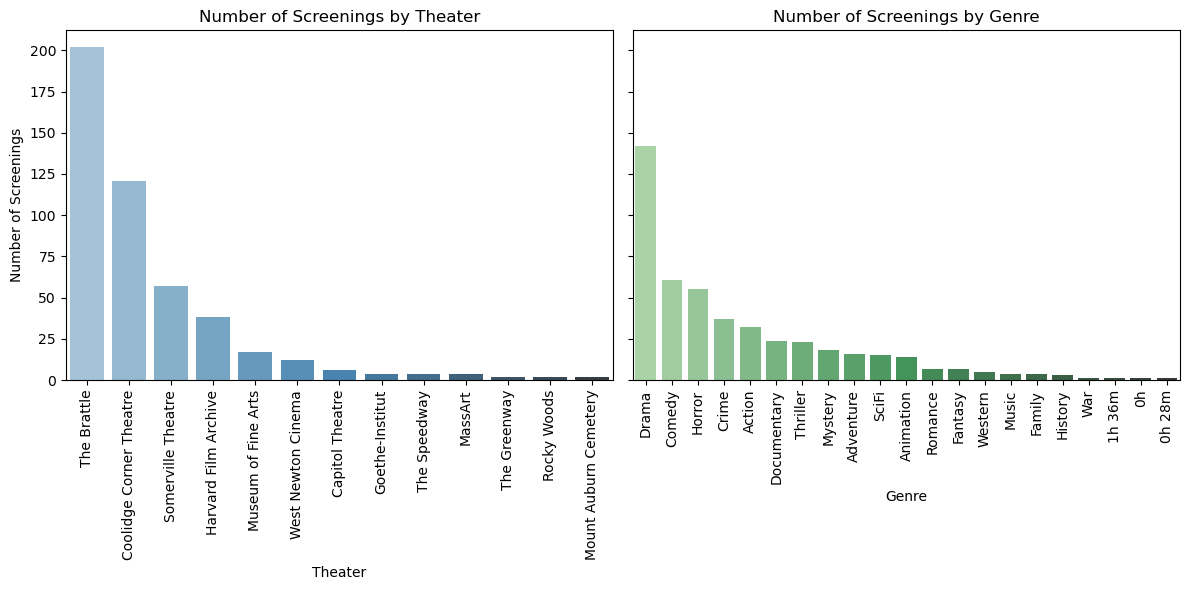

In [ ]:
# 2. Screenings by theater & screenings by genre

# Group by theater and genre to count the number of screenings
screenings_by_theater = df['theater'].value_counts()
screenings_by_genre = df['genre'].value_counts()

# Set up the subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot 1: Number of screenings by theater
sns.barplot(x=screenings_by_theater.index, y=screenings_by_theater.values, ax=ax1, palette='Blues_d')
ax1.set_title('Number of Screenings by Theater')
ax1.set_xlabel('Theater')
ax1.set_ylabel('Number of Screenings')
ax1.set_xticklabels(screenings_by_theater.index, rotation=90)

# Plot 2: Number of screenings by genre
sns.barplot(x=screenings_by_genre.index, y=screenings_by_genre.values, ax=ax2, palette='Greens_d')
ax2.set_title('Number of Screenings by Genre')
ax2.set_xlabel('Genre')
ax2.set_xticklabels(screenings_by_genre.index, rotation=90)

# Adjust layout to avoid overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Group by the 'Theater' column and count the number of screenings for each theater
theater_screenings = df.groupby('theater').size().reset_index(name='Screening_Count')

# Sort by 'Screening_Count' in descending order and get the top 3 theaters
top_3_theaters = theater_screenings.sort_values(by='Screening_Count', ascending=False).head(3)

# Print the top 3 theaters by the number of screenings
print(top_3_theaters)

                   theater  Screening_Count
9              The Brattle              202
1  Coolidge Corner Theatre              121
8       Somerville Theatre               57


By plotting screenings by theater and genre on a shared y-axis, we observe in the left plot that the top three theaters with the highest number of screenings are The Brattle, Coolidge Corner Theatre, and Somerville Theatre. In the right plot, which also shares the y-axis, Drama emerges as the genre with the highest number of screenings. The top three genres by screening count, Drama, Comedy, and Horror, are also shown in the right figure.

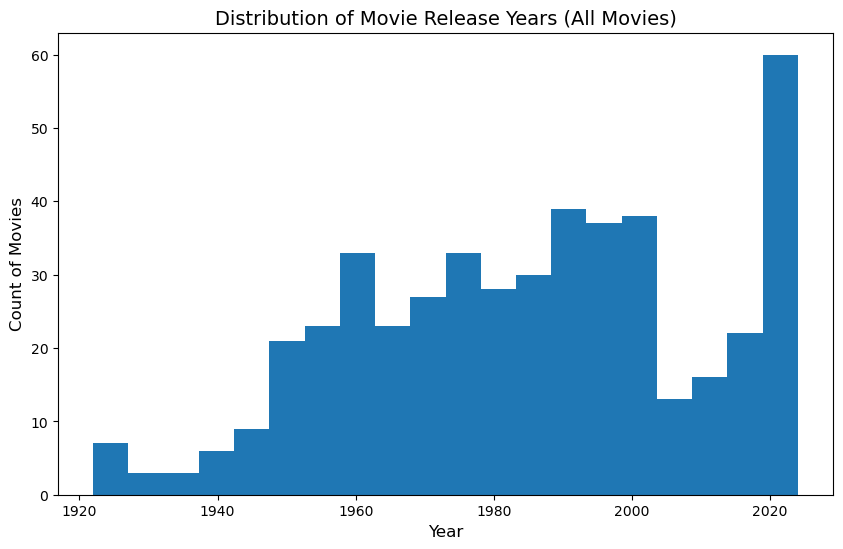

In [ ]:
# 3. Year distribution & distribution of year by theater
# Plot 1: Distribution of 'year' for all movies
plt.figure(figsize=(10, 6))
df['year'].hist(bins=20)
plt.title('Distribution of Movie Release Years (All Movies)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count of Movies', fontsize=12)
plt.grid(False)
plt.show()

From the distribution of movie release years, we observe an increasing trend in the number of movies released between 1950 and 2000. However, there is a significant drop in the number of movies released between 2000 and 2020. Interestingly, after 2020, there is a notable peak in the number of movie releases.

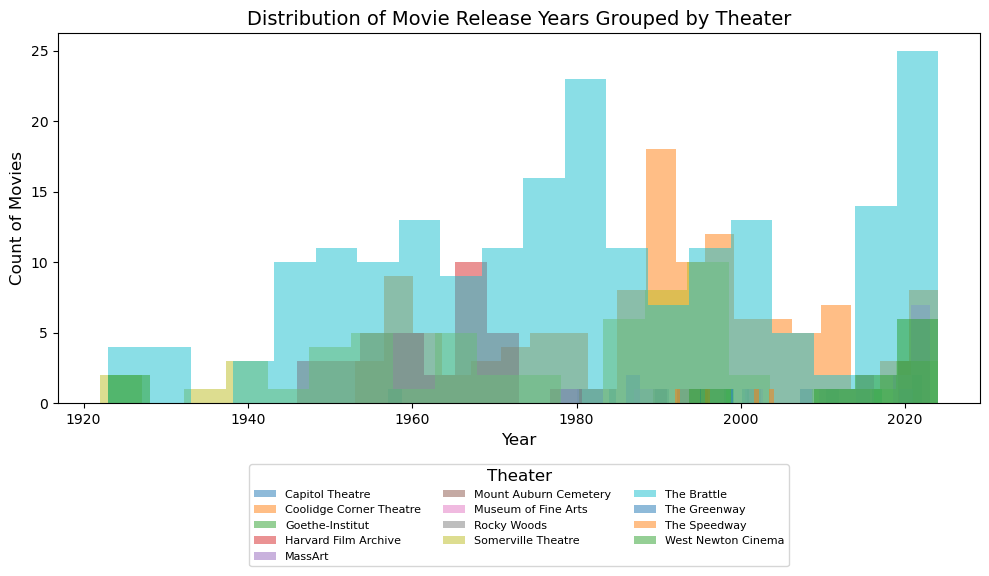

In [ ]:
# Plot 2: Distribution of 'year' grouped by theater
plt.figure(figsize=(10, 6))
df.groupby('theater')['year'].hist(alpha=0.5, bins=20, legend=True)
plt.title('Distribution of Movie Release Years Grouped by Theater', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count of Movies', fontsize=12)
plt.grid(False)
plt.legend(title="Theater",fontsize=8, title_fontsize=12, ncol=3,  loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.show()

From the graph, we can observe a noticeable increase in the number of movies released in theaters between 1985 and 2000, as evidenced by the increased overlap. In contrast, the period between 1930 and 1940 had the fewest theatrical releases. Additionally, The Brattle Theatre consistently shows a high volume of movie releases across all years compared to other theaters, particularly between the year 1970 and 1990.


In [ ]:
# print (df)

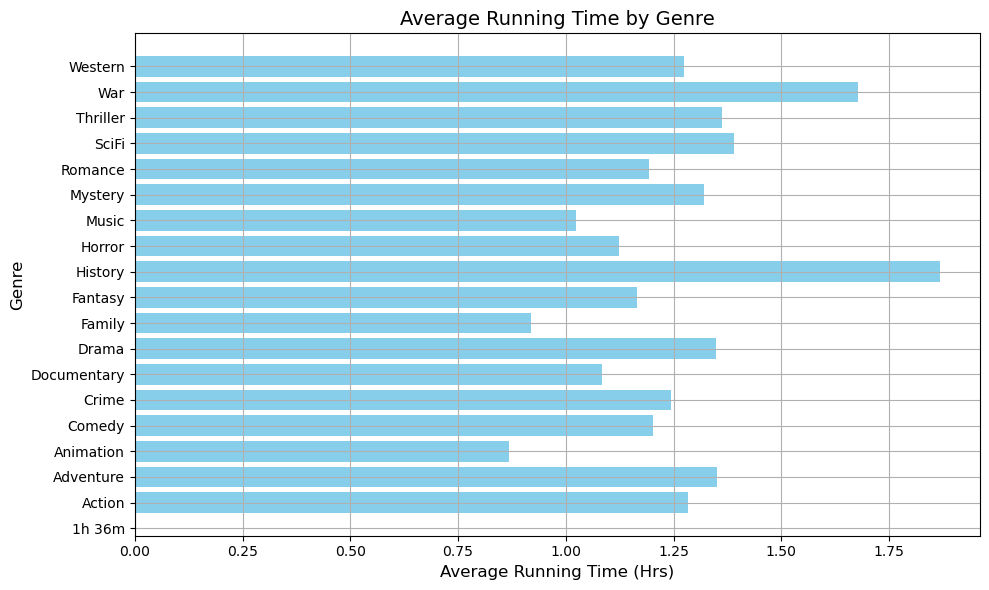

In [ ]:
# 4.1 Custom question 1
# Group by 'genre' and calculate the average runtime
genre_avg_runtime = df.groupby('genre')['runtime'].mean().reset_index()

# Convert runtime back to hours and minutes
genre_avg_runtime['runtime_minutes'] = genre_avg_runtime['runtime'] / 60

# Plotting the average runtime by genre
plt.figure(figsize=(10, 6))
plt.barh(genre_avg_runtime['genre'], genre_avg_runtime['runtime_minutes'], color='skyblue')
plt.title('Average Running Time by Genre', fontsize=14)
plt.xlabel('Average Running Time (Hrs)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

My first custom question is: Do different genres have varying running times? To explore this, I constructed a bar plot to analyze the average running time by genre. The plot reveals that History and War films tend to have longer running times compared to other genres.

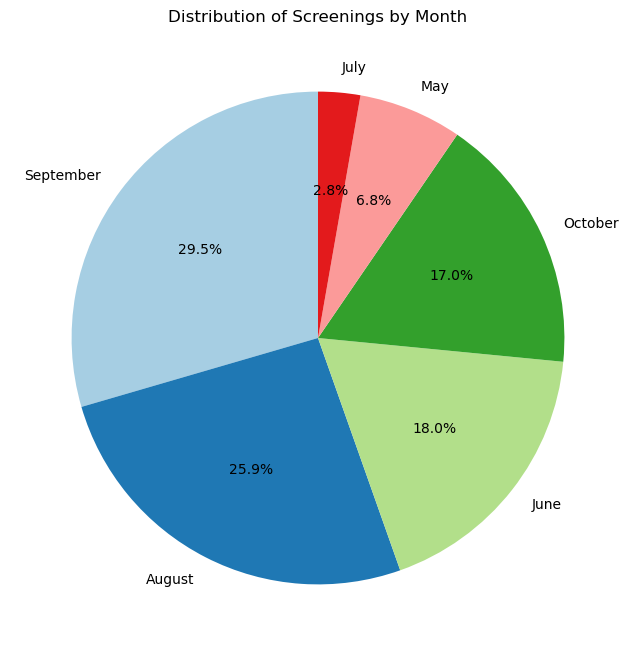

In [ ]:
# 4.2 Custom question 2
df['month'] = df['screen_date'].dt.strftime('%B')  # Get month names

# Count the number of screenings per month
month_counts = df['month'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
month_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Screenings by Month')
plt.ylabel('')  # Hide the y-label for a cleaner look
plt.show()

My second customized question is: Does the month of the year influence movie screenings? I consolidated the screen dates of all movies into months and plotted a pie chart. From the chart, we can observe that September and August have the highest number of movie screenings throughout the year.

<div class=md>
    <h3>6. Get a film's Wikipedia page identifier</h3>

The screenboston page has relatively little information about each film.  But we can use some of the what we *do* know about each film to query Wikipedia for additional data.
<div class=prompt>
    
  Find a unique identifier for the Wikipedia page for each film and store it in a new 'wiki_id' column. This could be the URL itself or a unique page ID that will allow you to recover the URL. Display the head of your updated DataFrame and describe your approach. You should strive to find page identifiers for as many films as possible, but don't worry if you can't find them all. Shoot for at least 50%.
</div>

**Hints:**
- One way to do this is to construct a query string to that can be appended to wikipeda's search URL:<br>
<code>'https://en.wikipedia.org/w/index.php?search='`</code><br>
You could use movie info from your DataFrame to construct the query string. This could include the title, year, the fact that it is a film, etc. A unqiue identifier such as a URL or page ID can then be extracted from the approapriate search. 
- Feel free to explore wikipedia's API options as an alternative using the search URL.
- Depending on your implementation, this process could take anywhere from a few seconds to a few minutes. To avoid unnecessary requests (and waiting) you should once again write your results to a file and only make requests if this file does not already exist. This point won't be repeated any more in this assignment but you should follow this principle whenever possible to avoid repeating any long tasks or computations.
- Most of the time taken by a request is spend waiting for a response. Asynchronous requests allow you to initiate new requests without having to wait for the previous one to be returned. You can explore the asyncio and aiohttp libraries (imported above) if you'd like to optimize your code for speed. Just be warned that these are very deep topics in themselves so this should really just be an optimization step for the curious. To complicate matters, asyncio works slightly differently in Jupyter notebooks than in Python scripts. Finally, making too many requests too quickly can cause some to fail or may even result in your IP being temporarily blocked by a server.

</div>

In [ ]:
# Wikipedia search URL template
wiki_search_url = "https://en.wikipedia.org/w/index.php?search="

# Function to search Wikipedia and get a movie's page identifier
def get_wikipedia_id(movie_title, movie_year):
    # Construct the search query
    search_query = f"{movie_title} {movie_year} film"
    search_url = wiki_search_url + search_query.replace(" ", "+")  # URL-friendly format
    
    # Make the request to Wikipedia
    response = requests.get(search_url)
    
    if response.status_code == 200:
        # Return the search URL as a placeholder for wiki ID
        return response.url
    else:
        return None  # Return None if the request fails

# Create a new column in the DataFrame for Wikipedia page identifiers
df['wiki_id'] = df.apply(lambda row: get_wikipedia_id(row['title'], row['year']), axis=1)

# Display the head of the updated DataFrame
df.head()

# Display the first few rows of the updated DataFrame
df[['title', 'year', 'wiki_id']].head()

,title,year,wiki_id
114,Ghost Dog: The Way of the Samurai,1999,https://en.wikipedia.org/w/index.php?search=Gh...
115,Stray Dog,1949,https://en.wikipedia.org/w/index.php?search=St...
116,Big Trouble in Little China,1986,https://en.wikipedia.org/w/index.php?search=Bi...
124,Ring,1998,https://en.wikipedia.org/w/index.php?search=Ri...
117,Young Frankenstein,1974,https://en.wikipedia.org/w/index.php?search=Yo...


In [ ]:
print (df.head())

                                 title       directors  year   genre  \
114  Ghost Dog: The Way of the Samurai    Jim Jarmusch  1999   Crime   
115                          Stray Dog  Akira Kurosawa  1949   Crime   
116        Big Trouble in Little China  John Carpenter  1986  Comedy   
124                               Ring    Hideo Nakata  1998  Horror   
117                 Young Frankenstein      Mel Brooks  1974  Comedy   

            runtime                  theater screen_date      screen_times  \
114 0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM   
115 0 days 02:02:00              The Brattle  2024-05-24           6:30 PM   
116 0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM   
124 0 days 01:36:00       Somerville Theatre  2024-05-25          11:59 PM   
117 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM   

    month                                            wiki_id  
114   May  https://en.wikipedia.org

In [ ]:
# Display results of updated df
missing_rows = df[df.wiki_id.isna()]
num_wiki_id_na = missing_rows.shape[0]
print("Number of screenings missing a wiki ID:", num_wiki_id_na)
if num_wiki_id_na > 0:
    print("Example rows with missing wiki ID")
    display.display(missing_rows)

Number of screenings missing a wiki ID: 0


*your answer here*



For this task, I used the Wikipedia API to search for movie titles and retrieve page identifiers, such as URLs or page IDs. The first step was to construct a search query and then use it to query Wikipedia for movie information. Next, I extracted the unique identifiers (e.g., URL or ID). Finally, I stored the results and handled any missing data in the process.

In [ ]:
grader.check("q6")

q6 results: All test cases passed!

<div class='md'>
    
<h3>7. Acquire HTML from wiki page and store in DataFrame</h3>

<div class=prompt>
    
Use `'wiki_id'` to acquire the HTML content of each film's Wikipedia page and store it in a new column called `'wiki_html'`.
</div>
</div>

In [ ]:
# Function to acquire HTML from the Wikipedia page using the URL stored in 'wiki_id'
def get_wikipedia_html(wiki_url):
    try:
        # Send a GET request to fetch the page content
        response = requests.get(wiki_url)
        if response.status_code == 200:
            return response.text  # Return the raw HTML content
        else:
            return None  # Return None if the request fails
    except Exception as e:
        return None  # Return None if an error occurs during the request

# Create a new column 'wiki_html' where we will store the HTML content of each Wikipedia page
df['wiki_html'] = df['wiki_id'].apply(lambda url: get_wikipedia_html(url) if pd.notnull(url) else None)

# Display the head of the updated DataFrame
df[['title', 'year', 'wiki_id', 'wiki_html']].head()

# Display the first few rows of the updated DataFrame
df[['title', 'year', 'wiki_html']].head()

,title,year,wiki_html
114,Ghost Dog: The Way of the Samurai,1999,"<!DOCTYPE html>\n<html class=""client-nojs vect..."
115,Stray Dog,1949,"<!DOCTYPE html>\n<html class=""client-nojs vect..."
116,Big Trouble in Little China,1986,"<!DOCTYPE html>\n<html class=""client-nojs vect..."
124,Ring,1998,"<!DOCTYPE html>\n<html class=""client-nojs vect..."
117,Young Frankenstein,1974,"<!DOCTYPE html>\n<html class=""client-nojs vect..."


In [ ]:
# Display results of updated df
missing_rows = df[df.wiki_html.isna()]
num_wiki_html_na = missing_rows.shape[0]
print("Number of screenings missing wiki HTML:", num_wiki_html_na)
if num_wiki_html_na > 0:
    print("Example rows with missing wiki HTML")
    display.display(missing_rows)

Number of screenings missing wiki HTML: 0


In [ ]:
grader.check("q7")

q7 results: All test cases passed!

In [ ]:
# first_wiki_html = df['wiki_html'].iloc[1]

# # Define the output file path
# output_txt_path = './data/first_wiki_html_0923_11pm_1.txt'

# # Save the content to a text file
# with open(output_txt_path, 'w', encoding='utf-8') as file:
#     file.write(first_wiki_html if pd.notnull(first_wiki_html) else "No content")

# output_txt_path  # Return the file path to confirm where it's saved

<div class=md>

<h3>8. Adding Data from Wikipedia and Asking New Questions</h3>

Now that we have Wikipedia pages for most or all of our movies, we can add supplemental data from those pages to our DataFrame, ask new questions, and use Pandas and visualizations to try and get some answers. This final section is very open-ended, and you are encouraged to experiment. We want to see what you can do!

<div class='prompt'>

1. **Data Extraction and Integration**
   - Extract at least one new piece of data from each movie page you found.
   - Add this data as a new column(s) to your DataFrame.
   - Display the head of your updated DataFrame.
   - Discuss your strategy for extracting the new data, including any challenges you faced and how you overcame them.

2. **Data Analysis and Visualization**
    - Formulate at least two new questions that involve the Wikipedia data you've added.
    - For each question:
      - Clearly state your question and why it's interesting or relevant.
      - Describe your approach to answering the question.
      - Use Pandas to manipulate and analyze the data as needed.
      - Create at least one meaningful visualization that helps answer your question.
      - Ensure your plots are well-labeled and easy to interpret.
      - Interpret the results of your analysis, discussing any insights, patterns, or surprises you discovered.

</div>

**Hints:**
- The 'info box' on the right side of most Wikipedia pages is fairly standardized across film pages. This might be the easiest place to start.
- Some potential pieces of data to extract include the language of the film, its box office revenue or budget, the starring cast, etc.
- Feel free to extract more than just a single new piece of data to use in your analysis. If you're feeling particularly adventurous, you can even jump from the film page to other linked pages to acquire more data!
- Consider how the new data you've extracted might relate to the screening information you already have. Are there interesting connections or patterns to explore?

Remember, the goal is to demonstrate your ability to ask insightful questions, use appropriate data science techniques to answer them, and effectively communicate your findings.
</div>

In [ ]:
print (df.head())

                                 title       directors  year   genre  \
114  Ghost Dog: The Way of the Samurai    Jim Jarmusch  1999   Crime   
115                          Stray Dog  Akira Kurosawa  1949   Crime   
116        Big Trouble in Little China  John Carpenter  1986  Comedy   
124                               Ring    Hideo Nakata  1998  Horror   
117                 Young Frankenstein      Mel Brooks  1974  Comedy   

            runtime                  theater screen_date      screen_times  \
114 0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM   
115 0 days 02:02:00              The Brattle  2024-05-24           6:30 PM   
116 0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM   
124 0 days 01:36:00       Somerville Theatre  2024-05-25          11:59 PM   
117 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM   

    month                                            wiki_id  \
114   May  https://en.wikipedia.or

In [ ]:
# type(df['wiki_html'].iloc[1])

In [ ]:
# 1. Data Extraction and Integration
# Function to extract the year from the <title> tag
def extract_year(title):
    # Use a regular expression to find the year (a 4-digit number) in the string
    match = re.search(r'\b(19|20)\d{2}\b', title)
    if match:
        return match.group(0)
    return None

# Apply the function to the 'wiki_html' column and save the result in a new column 'Produce Year'
df['Produce Year'] = df['wiki_html'].apply(extract_year)

# Display the updated DataFrame
print(df.head())

                                 title       directors  year   genre  \
114  Ghost Dog: The Way of the Samurai    Jim Jarmusch  1999   Crime   
115                          Stray Dog  Akira Kurosawa  1949   Crime   
116        Big Trouble in Little China  John Carpenter  1986  Comedy   
124                               Ring    Hideo Nakata  1998  Horror   
117                 Young Frankenstein      Mel Brooks  1974  Comedy   

            runtime                  theater screen_date      screen_times  \
114 0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM   
115 0 days 02:02:00              The Brattle  2024-05-24           6:30 PM   
116 0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM   
124 0 days 01:36:00       Somerville Theatre  2024-05-25          11:59 PM   
117 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM   

    month                                            wiki_id  \
114   May  https://en.wikipedia.or

In [ ]:
print (df.head())

                                 title       directors  year   genre  \
114  Ghost Dog: The Way of the Samurai    Jim Jarmusch  1999   Crime   
115                          Stray Dog  Akira Kurosawa  1949   Crime   
116        Big Trouble in Little China  John Carpenter  1986  Comedy   
124                               Ring    Hideo Nakata  1998  Horror   
117                 Young Frankenstein      Mel Brooks  1974  Comedy   

            runtime                  theater screen_date      screen_times  \
114 0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM   
115 0 days 02:02:00              The Brattle  2024-05-24           6:30 PM   
116 0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM   
124 0 days 01:36:00       Somerville Theatre  2024-05-25          11:59 PM   
117 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM   

    month                                            wiki_id  \
114   May  https://en.wikipedia.or

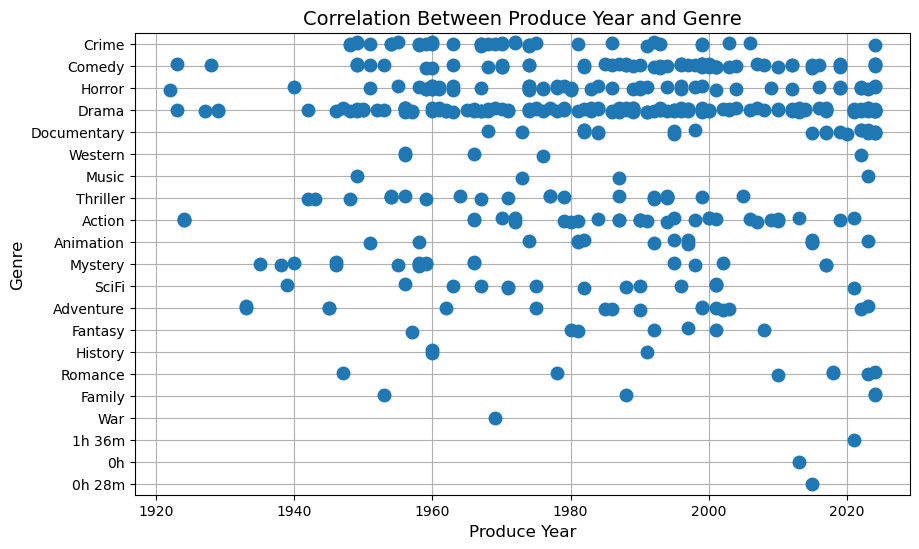

In [ ]:
# 2. Data Analysis and Visualization
# Convert 'Produce Year' to numeric (if needed)
df['Produce Year'] = pd.to_numeric(df['Produce Year'], errors='coerce')

# Create a correlation plot using seaborn strip plot (or you can use scatterplot)
plt.figure(figsize=(10, 6))
sns.stripplot(x='Produce Year', y='genre', data=df, jitter=True, size=10)

# Set plot labels and title
plt.title('Correlation Between Produce Year and Genre', fontsize=14)
plt.xlabel('Produce Year', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# # Save the DataFrame to a CSV file excluding the 'wiki_id' and 'wiki_html' columns
# df.drop(columns=['wiki_id', 'wiki_html'], inplace=False).to_csv('./data/movies_excluding_wiki_columns.csv', index=False)

# # Output the path where the file is saved
# './data/movies_excluding_wiki_columns.csv'

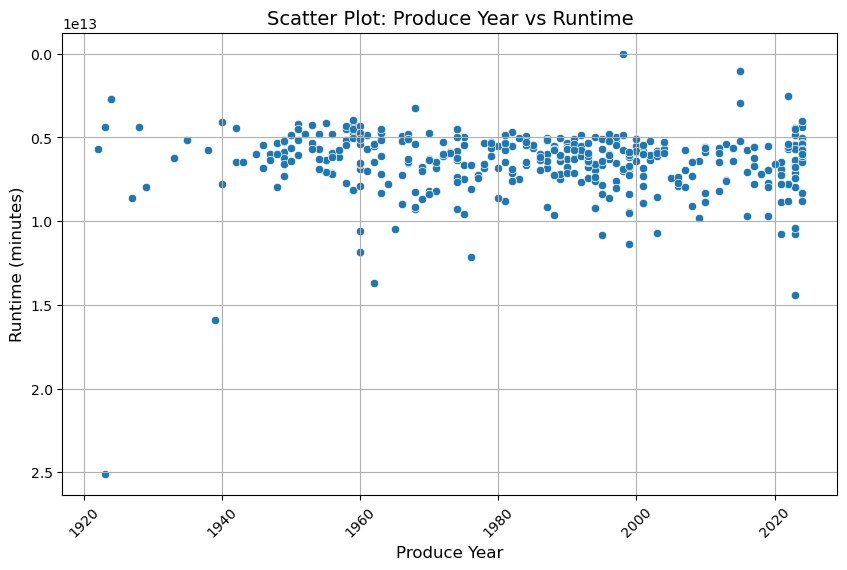

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Produce Year', y='runtime', data=df)

# Add labels and title
plt.title('Scatter Plot: Produce Year vs Runtime', fontsize=14)
plt.xlabel('Produce Year', fontsize=12)
plt.ylabel('Runtime (minutes)', fontsize=12)

# Show plot with rotated x-axis labels for readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In the Data Extraction and Integration section, I extracted each movie’s production year from Wikipedia and saved it in a new column labeled 'Produce Year'. Below is a display of the DataFrame's head. The extraction strategy involved identifying relevant keywords on Wikipedia and retrieving these from each movie's Wikipedia page to store them accordingly.

For the second part, Data Analysis and Visualization, I formulated two key questions:

1.The first question explores the correlation between a movie's production year and its genre to identify any patterns or differences.

2.The second question examines the relationship between running time and production year to determine if there are any noticeable trends.

From the analysis, the findings for the first question suggest that Drama, Horror, and Comedy are the most frequently produced genres across all production years. The results for the second question indicate that, while there isn’t a significant difference in running times across production years, there appears to be a slight decrease in running time as the production year increases. This points to a weak correlation between production year and running time, but further verification through a regression model could be implemented.

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

The most challenging part was extracting information using the API in Q3, which took much longer than I expected.

In [ ]:
hours_spent_on_hw = 20

In [ ]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 12.24 minutes for this notebook to run


🌈 **This concludes HW1. Thank you!**